In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
# import sklearn
# print("sklearn version: ", sklearn.__version__)
# assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

TF version:  2.4.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np
import pandas as pd
import os
import time
# import scoring as scoring
import pickle
import gzip
from pyarrow import csv
import csv
# train_path = "D:/2022AIComp_data/train.csv"
# test_path = "D:/2022AIComp_data/test.csv"

#---------------------- Load Train,Test DF
train_pd = pd.read_csv("D:/2022AIComp_data/train.csv")
test_pd = pd.read_csv("D:/2022AIComp_data/test.csv")

print("Train: %s, Test: %s" %(train_pd.shape, test_pd.shape))
train_pd.head()
print(train_pd.iloc[:,0].unique())
# test_pd.head()

Train: (33600, 514), Test: (7820, 514)
['out' 'in' 'normal' 'other' 'noise']


In [15]:
def data_shape(data_li):
    for data in data_li:
        vnames = [name for name in globals() if globals()[name] is data]
        print(vnames[0],'.shape : ',data.shape)

def data_shape_lo(data_li):
    for data in data_li:
        vnames = [name for name in locals() if locals()[name] is data]
        
        
        
X_train = np.array(train_pd.iloc[:,1:])
y_train = train_pd.iloc[:,0].replace(['out','in', 'normal', 'other', 'noise'],[0,1,2,3,4])
# y_train = np.argmax(np.array(pd.get_dummies(train_pd.iloc[:,0])),axis=1)

submit_test = np.array(test_pd.iloc[:,1:])
# y_test = np.array(pd.get_dummies(test_pd.iloc[:,0]))


# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state = 42, stratify = y_train)
# data_shape([X_train,X_test,submit_test])


In [107]:
# #data Normalize
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = StandardScaler()
# # scaler = MinMaxScaler()
# X_scaled = scaler.fit(X_train).transform(X_train)
# X_test_scaled = scaler.transform(X_test)


In [16]:
def data_remake_4(X_train,y_train):
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state = 42, stratify = y_train)
    
    X_train4 = X_train[y_train != 2]
    y_train4 = y_train[y_train !=2]

    X_test4 = X_test[y_test != 2]
    y_test4 = y_test[y_test !=2]


    y_train4[y_train == 3] = 2
    y_train4[y_train==4]=3

    y_test4[y_test == 3] = 2
    y_test4[y_test==4]=3
    print(np.unique(y_train4))
    # print(np.unique(y_test4))


#     data_shape([X_train4,X_test4,y_train4,y_test4])
    return X_train4,X_test4,y_train4,y_test4

X_train_4,X_test_4,y_train_4,y_test_4 =data_remake_4(X_train[:,:100],y_train)
data_shape([X_train_4,X_test_4,y_train_4,y_test_4])





[0 1 2 3]
X_train_4 .shape :  (12480, 100)
X_test_4 .shape :  (3120, 100)
y_train_4 .shape :  (12480,)
y_test_4 .shape :  (3120,)


## IFFT 해서 timedomain으로

In [48]:

X_train = abs(np.fft.ifft(X_train)*2000)
X_test = abs(np.fft.ifft(X_test)*2000)
submit_test= abs(np.fft.ifft(X_test)*2000)
data_shape([X_train,X_test,submit_test])

X_train .shape :  (12480, 513)
X_test .shape :  (3120, 513)
submit_test .shape :  (3120, 513)


## STFT

In [49]:
from scipy import signal
f, t, X_train = signal.stft(X_train,fs = 1000, nperseg=50)
f, t, X_test = signal.stft(X_test,fs = 1000, nperseg=50)
f, t, submit_test = signal.stft(submit_test,fs = 1000, nperseg=50)
print(X_train.shape)

In [42]:
# X_train =X_train.reshape((-1,X_train.shape,18,1))
# X_test = X_test.reshape((-1,43,18,1))
# submit_test = submit_test.reshape((-1,43,18,1))

## 첨도

In [74]:
from scipy.stats import skew, kurtosis


for i in range(X_train.shape[0]):
#     X_train[i] = skew(X_train[i])
    X_train[i] = kurtosis(X_train[i], fisher=True)
# X_train =  X_train.reshape((-1,27,19,1))

print(X_train.shape)


for i in range(X_test.shape[0]):
    X_test[i] = skew(X_test[i])
#     X_train[i] = kurtosis(X_train[i], fisher=True)
# X_test =  X_test.reshape((-1,27,19,1))

print(X_test.shape)

for i in range(submit_test.shape[0]):
    submit_test[i] = skew(submit_test[i])
#     X_train[i] = kurtosis(X_train[i], fisher=True)
# submit_test =  submit_test.reshape((-1,27,19,1))

print(submit_test.shape)

(12480, 513)
(3120, 513)
(7820, 513)


In [12]:
from datetime import datetime
c= datetime.now()
a = c.strftime('%Y-%m-%d_%H_%M')
print(a)

import time

def hms(s):
    hours = s // 3600
    s = s - hours*3600
    mu = s // 60
    ss = s - mu*60
    return hours, mu, ss


##dense layer 바꿈
from tensorflow import keras
from datetime import datetime
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

#####
def train_model(model,X_train=X_train_4,y_train = y_train_4,
                X_test=X_test_4,y_test=y_test_4, batch_size = 128,
                optimizer='adam',patience=10, matrix = True,
                class_weight=True, epoch = 100,reshape = False, make_csv = False,):

    c = datetime.now() ##모델 돌릴 때 시작 시간
    n_time = c.strftime('%Y-%m-%d_%H_%M')
    print(n_time)

    
    if reshape ==True: ##데이터 reshape -> 1d 로 돌릴때
        X_tr=X_train.reshape((-1,X_train.shape[1],X_train.shape[2],1))
        X_te=X_test.reshape((-1,X_test.shape[1],X_test.shape[2],1))
    else:
        X_tr = X_train
        X_te = X_test
        
    print('train_model 안에서')
    data_shape([X_tr,X_te])
    
    
    MODEL_SAVE_FOLDER_PATH = './model_4/'  #모델 저장 경로
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    model_path = MODEL_SAVE_FOLDER_PATH + str(n_time)+'.hdf5'


    es = EarlyStopping(monitor='val_loss', mode='min', 
                       verbose=1, patience=patience, restore_best_weights = True)

    mc = ModelCheckpoint(model_path, monitor='val_loss',
                         mode='min', save_best_only=True)

    if class_weight==True:
        class_weights = compute_class_weight(class_weight = 'balanced',
                                                         classes = np.unique(y_train),
                                                         y = y_train)
        class_weights = dict(enumerate(class_weights))
    else:
        class_weights = None


    model.compile(loss='sparse_categorical_crossentropy',
                          optimizer = optimizer
                         ,metrics=['accuracy'])


    start = time.time()

    #model fit
    history = model.fit(X_tr,y_train, epochs = epoch,
                     batch_size=batch_size, validation_split=0.2, 
                                callbacks=[es, mc],
                               class_weight = class_weights,
                                shuffle=True,
                       ).history

    terminate_time = time.time() - start
    
    # training time
    hours, mu, ss = hms(terminate_time)
    print('training time: ', hours, 'h', mu, 'm', ss, 's')    
    print('\n-----test score : ',model.evaluate(X_te, y_test))
    
    #러닝 커브
    plt.plot(history['accuracy'], label='train_acc')
    plt.plot(history['val_accuracy'], label= 'val_acc')
    plt.plot(history['loss'], label= 'train_loss')
    plt.plot(history['val_loss'], label= 'val_loss')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.legend(loc='lower left')
    plt.show()
    
    
    print_acc(model, matrix=True ,X_te=X_test,y_test=y_test, reshape = reshape)
    
    if(make_csv == True):
        submit_pd = make_test_csv(model,model_name = n_time, reshape=reshape)
        return submit_pd

    
    
# inference     
import seaborn as sns
from sklearn.metrics import confusion_matrix


def print_acc(model, matrix =True, X_te=X_test_4,y_test=y_test_4,reshape = False):
    
    if reshape ==True: ##데이터 reshape -> cnn 돌릴때
        X_te=X_test.reshape((-1,X_te.shape[1],X_te.shape[2],1))
    else:
        X_te = X_te
        
    data_shape([X_te])
    
    y_pred = np.argmax(model.predict(X_te),axis =1)
    cf = confusion_matrix(y_test, y_pred)

    per_cf =[]
    for i in cf:
        per_cf.append(i/np.sum(i))
    axes=[]
#     plt.rc('font', size=10)
    for i , cf in enumerate([cf, per_cf]):
        fig=plt.figure(figsize=(8,8))
        axes.append(fig.add_subplot(2,2,i+1))
        ax = sns.heatmap(np.round(cf,4),annot=True, fmt='', cmap='Blues')#확률로 표시
        ax.set_title('Seaborn Confusion Matrix with labels\n\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');
        fig.tight_layout()
        ## Display the visualiztion of the Confusion Matrix.
        plt.show()
        
        
def make_test_csv(model,model_name,reshape=False):
    sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
    sample_pd.set_index('id',inplace=True)
    
    if reshape == True:
        submit_te = submit_test.reshape((-1,27,19,1))
    else:
        submit_te=submit_test
    pred = np.argmax(model.predict(submit_te),axis = 1)
    print(pred.shape)
    sub = pd.concat([test_pd.iloc[:,0],
                           pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
    sub.set_index('id',inplace=True)
    submit_pd = sub.reindex(sample_pd.index)
    print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
    plt.hist(np.array(submit_pd))
    plt.show()
    
    MODEL_SAVE_FOLDER_PATH = './result_csv/' 
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name[:-5]+'.csv')
    print(model_name)
    return submit_pd
    

    
def load_model_list(dir_name):
    for dirname,_, filenames in os.walk(dir_name):
        model_list= filenames
        print(filenames) 
        
        
def show_matrix(y_test,y_pred):
    cf = confusion_matrix(y_test, y_pred)

    per_cf =[]
    for i in cf:
        per_cf.append(i/np.sum(i))
    axes=[]
#     plt.rc('font', size=10)
    for i , cf in enumerate([cf, per_cf]):
        fig=plt.figure(figsize=(8,8))
        axes.append(fig.add_subplot(2,2,i+1))
        ax = sns.heatmap(np.round(cf,4),annot=True, fmt='', cmap='Blues')#확률로 표시
        ax.set_title('Seaborn Confusion Matrix with labels\n\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');
        fig.tight_layout()
        ## Display the visualiztion of the Confusion Matrix.
        plt.show()

2022-06-18_15_40


## 4개로 돌리기

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_36 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_37 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_38 (Batc (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 4, 64)         

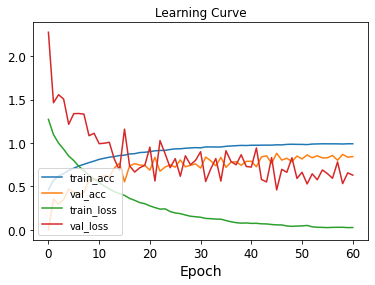

C:\Users\GJ\AppData\Local\Temp\ipykernel_13588\1245549418.py:108: RuntimeWarning: invalid value encountered in true_divide
  per_cf.append(i/np.sum(i))


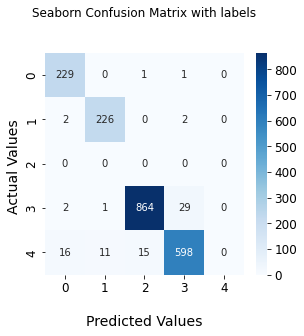

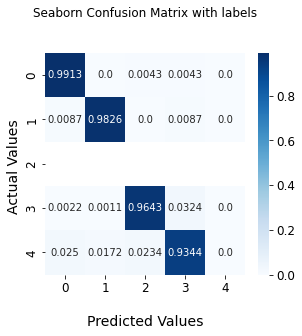

In [41]:
batch_size= 64
X_train
model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train4,y_train4,X_test4,y_test4,batch_size,patience = 15,optimizer = 'sgd',reshape=True, class_weight=True)

In [26]:
X_train_4.shape
y_train_4.shape

(9984,)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_48 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_49 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_50 (Batc (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 6, 4, 64)        

125/125 [==============================] - 1s 7ms/step - loss: 0.0657 - accuracy: 0.9758 - val_loss: 0.6820 - val_accuracy: 0.8137
Epoch 45/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0792 - accuracy: 0.9681 - val_loss: 0.5411 - val_accuracy: 0.8383
Epoch 46/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0495 - accuracy: 0.9858 - val_loss: 0.5502 - val_accuracy: 0.8483
Epoch 47/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0472 - accuracy: 0.9838 - val_loss: 0.5484 - val_accuracy: 0.8503
Epoch 48/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0418 - accuracy: 0.9866 - val_loss: 0.5479 - val_accuracy: 0.8468
Epoch 49/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0363 - accuracy: 0.9892 - val_loss: 0.5707 - val_accuracy: 0.8633
Epoch 50/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0338 - accuracy: 0.9888 - val_loss: 0.6020 - val_accuracy: 0.8413
Epoch

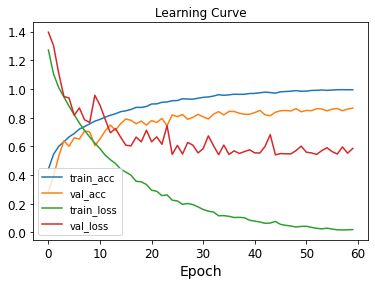

X_test_4 .shape :  (2496, 27, 19, 1)
y_test_4 .shape :  (2496,)


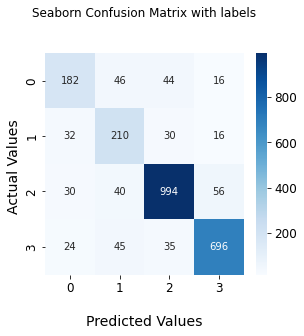

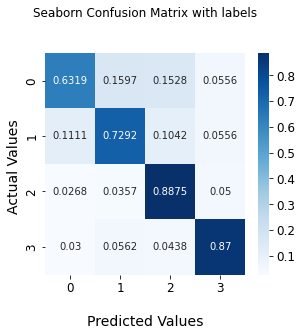

In [48]:
####FFT 마지막 제대로

batch_size= 64


X_train_4 = X_train_4.reshape(-1,27,19,1)
X_test_4 = X_test_4.reshape(-1,27,19,1)


model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model = model,X_train = X_train_4, X_test = X_test_4,
            batch_size = batch_size, patience = 15,
            optimizer = 'sgd',reshape=False, class_weight=True)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_52 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_53 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_54 (Batc (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 4, 64)        

125/125 [==============================] - 1s 7ms/step - loss: 0.0686 - accuracy: 0.9760 - val_loss: 0.5919 - val_accuracy: 0.8187
Epoch 45/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0695 - accuracy: 0.9787 - val_loss: 0.5241 - val_accuracy: 0.8433
Epoch 46/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0622 - accuracy: 0.9769 - val_loss: 0.5814 - val_accuracy: 0.8307
Epoch 47/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0675 - accuracy: 0.9759 - val_loss: 0.5790 - val_accuracy: 0.8317
Epoch 48/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0767 - accuracy: 0.9689 - val_loss: 0.5320 - val_accuracy: 0.8443
Epoch 49/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0651 - accuracy: 0.9757 - val_loss: 0.5256 - val_accuracy: 0.8483
Epoch 50/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0528 - accuracy: 0.9828 - val_loss: 0.5733 - val_accuracy: 0.8247
Epoch

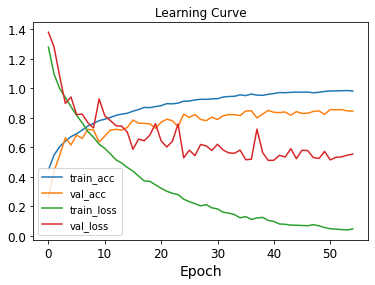

X_test_4 .shape :  (2496, 27, 19, 1)
y_test_4 .shape :  (2496,)


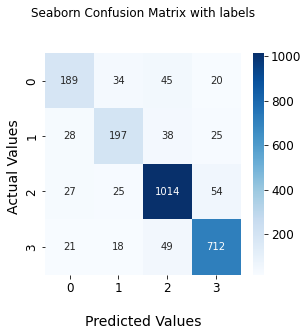

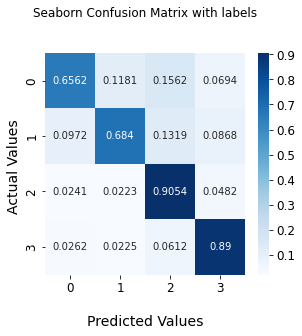

In [49]:
####FFT 마지막 제대로 , normal x

batch_size= 64


X_train_4 = X_train_4.reshape(-1,27,19,1)
X_test_4 = X_test_4.reshape(-1,27,19,1)


model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model = model,X_train = X_train_4, X_test = X_test_4,
            batch_size = batch_size, patience = 15,
            optimizer = 'sgd',reshape=False, class_weight=True)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_104 (Bat (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_105 (Bat (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_106 (Bat (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 6, 4, 64)        

Epoch 44/100
156/156 [==============================] - 1s 7ms/step - loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.6126 - val_accuracy: 0.8425
Epoch 45/100
156/156 [==============================] - 1s 6ms/step - loss: 0.0068 - accuracy: 0.9995 - val_loss: 0.7277 - val_accuracy: 0.8209
Epoch 46/100
156/156 [==============================] - 1s 7ms/step - loss: 0.0261 - accuracy: 0.9934 - val_loss: 0.6799 - val_accuracy: 0.8321
Epoch 47/100
156/156 [==============================] - 1s 7ms/step - loss: 0.0080 - accuracy: 0.9989 - val_loss: 0.6550 - val_accuracy: 0.8349
Epoch 48/100
156/156 [==============================] - 1s 7ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.6225 - val_accuracy: 0.8446
Epoch 49/100
156/156 [==============================] - 1s 7ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.6304 - val_accuracy: 0.8433
Epoch 50/100
156/156 [==============================] - 1s 6ms/step - loss: 0.0079 - accuracy: 0.9991 - val_loss: 0.6505 - val_accuracy:

training time:  0.0 h 1.0 m 42.57805848121643 s
98/98 [==============================] - 0s 3ms/step - loss: 0.7160 - accuracy: 0.8484

-----test score :  [0.7159939408302307, 0.848397433757782]


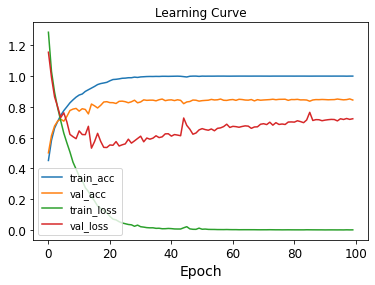

X_test_4 .shape :  (3120, 27, 19, 1)


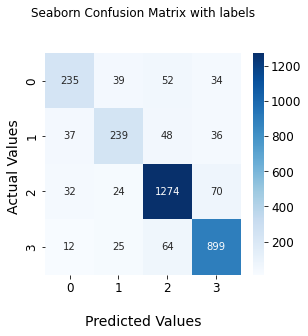

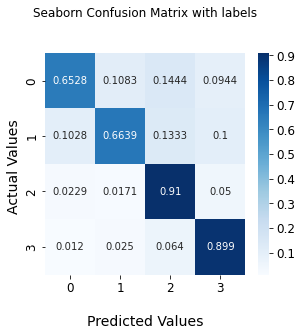

In [92]:
####FFT 마지막 제대로 , normal x, patience =100

batch_size= 64


X_train_4 = X_train_4.reshape(-1,27,19,1)
X_test_4 = X_test_4.reshape(-1,27,19,1)


model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model = model,X_train = X_train_4, X_test = X_test_4,
            batch_size = batch_size, patience = 100,
            optimizer = 'sgd',reshape=False, class_weight=True)

[0 1 2 3]
['X_train_4']
X_train_4 .shape :  (12480, 27, 19, 1)
['X_test_4']
X_test_4 .shape :  (3120, 27, 19, 1)
['y_train_4']
y_train_4 .shape :  (12480,)
['y_test_4']
y_test_4 .shape :  (3120,)
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_92 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_93 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 13, 9, 64)         25664     
_______________________________________________________

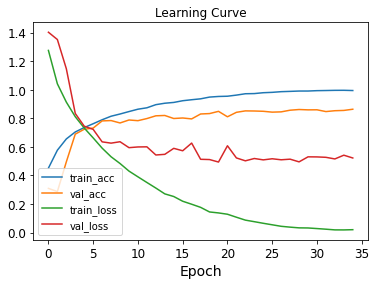

['X_test_4']
X_test_4 .shape :  (3120, 27, 19, 1)


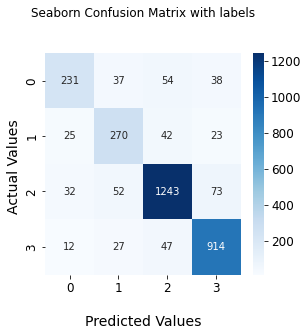

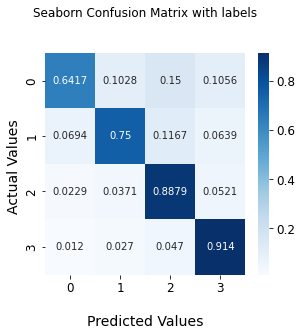

['X_test_4']
X_test_4 .shape :  (3120, 27, 19, 1)


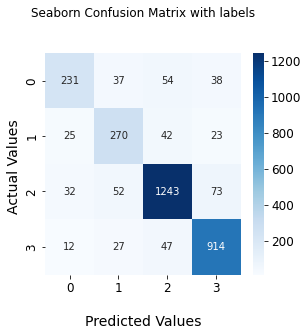

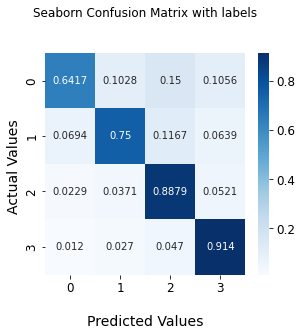

In [87]:
####FFT normalize O -> min max

X_train_4,X_test_4,y_train_4,y_test_4 =data_remake_4(X_train,y_train)

#data Normalize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_4 = scaler.fit(X_train_4).transform(X_train_4)
X_test_4 = scaler.transform(X_test_4)


batch_size= 64


X_train_4 = X_train_4.reshape(-1,27,19,1)
X_test_4 = X_test_4.reshape(-1,27,19,1)
data_shape([X_train_4,X_test_4,y_train_4,y_test_4])


model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model = model,X_train = X_train_4, X_test = X_test_4,
            batch_size = batch_size, patience = 15,
            optimizer = 'sgd',reshape=False, class_weight=True)



[0 1 2 3]
X_train_4 .shape :  (12480, 10, 10, 1)
X_test_4 .shape :  (3120, 10, 10, 1)
y_train_4 .shape :  (12480,)
y_test_4 .shape :  (3120,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_12 (Batc (None, 10, 10, 1)         4         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 16)        416       
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 64)          25664     
_________________________________________________________________
batch_normalization_14 (Batc (None, 5, 5, 64

Epoch 43/100
156/156 [==============================] - 1s 7ms/step - loss: 0.1200 - accuracy: 0.9542 - val_loss: 0.5180 - val_accuracy: 0.8413
Epoch 44/100
156/156 [==============================] - 1s 6ms/step - loss: 0.0995 - accuracy: 0.9639 - val_loss: 0.5078 - val_accuracy: 0.8454
Epoch 45/100
156/156 [==============================] - 1s 6ms/step - loss: 0.0963 - accuracy: 0.9605 - val_loss: 0.5576 - val_accuracy: 0.8277
Epoch 46/100
156/156 [==============================] - 1s 7ms/step - loss: 0.0962 - accuracy: 0.9651 - val_loss: 0.5107 - val_accuracy: 0.8498
Epoch 47/100
156/156 [==============================] - 1s 6ms/step - loss: 0.0950 - accuracy: 0.9663 - val_loss: 0.4660 - val_accuracy: 0.8662
Epoch 48/100
156/156 [==============================] - 1s 6ms/step - loss: 0.0773 - accuracy: 0.9692 - val_loss: 0.5081 - val_accuracy: 0.8526
Epoch 49/100
156/156 [==============================] - 1s 7ms/step - loss: 0.0902 - accuracy: 0.9683 - val_loss: 0.5193 - val_accuracy:

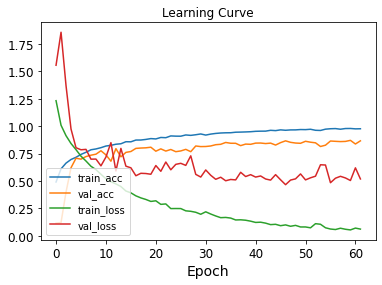

X_test_4 .shape :  (3120, 10, 10, 1)


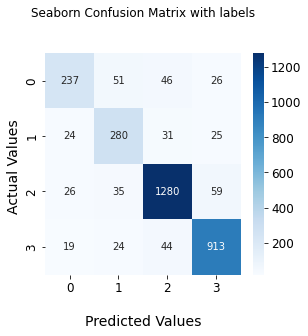

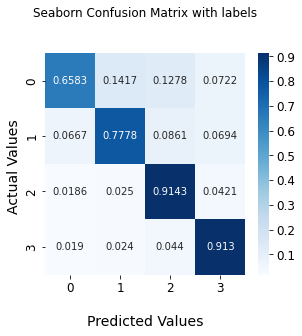

In [18]:
####FFT normalize O -> min max, 1000hz 까지만

X_train_4,X_test_4,y_train_4,y_test_4 =data_remake_4(X_train[:,:100],y_train)

#data Normalize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_4 = scaler.fit(X_train_4).transform(X_train_4)
X_test_4 = scaler.transform(X_test_4)


batch_size= 64


X_train_4 = X_train_4.reshape(-1,10,10,1)
X_test_4 = X_test_4.reshape(-1,10,10,1)
data_shape([X_train_4,X_test_4,y_train_4,y_test_4])


model = keras.models.Sequential([
    keras.Input(shape=(10,10,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model = model,X_train = X_train_4, X_test = X_test_4,
            y_train= y_train_4, y_test = y_test_4,
            batch_size = batch_size, patience = 15,
            optimizer = 'sgd',reshape=False, class_weight=True)



[0 1 2 3]
['X_train_4']
X_train_4 .shape :  (12480, 27, 19, 1)
['X_test_4']
X_test_4 .shape :  (3120, 27, 19, 1)
['y_train_4']
y_train_4 .shape :  (12480,)
['y_test_4']
y_test_4 .shape :  (3120,)
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_96 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_97 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 13, 9, 64)         25664     
_______________________________________________________

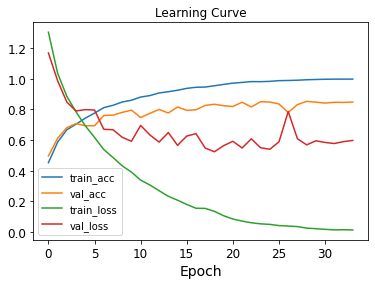

['X_test_4']
X_test_4 .shape :  (3120, 27, 19, 1)


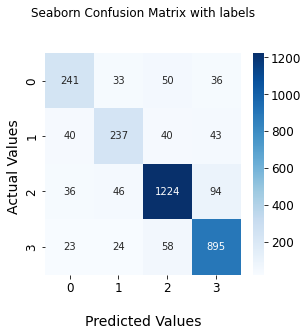

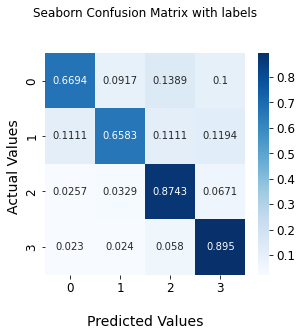

In [88]:
####FFT normalize O -> min ma

X_train_4,X_test_4,y_train_4,y_test_4 =data_remake_4(X_train,y_train)

#data Normalize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_4 = scaler.fit(X_train_4).transform(X_train_4)
X_test_4 = scaler.transform(X_test_4)


batch_size= 64


X_train_4 = X_train_4.reshape(-1,27,19,1)
X_test_4 = X_test_4.reshape(-1,27,19,1)
data_shape([X_train_4,X_test_4,y_train_4,y_test_4])


model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model = model,X_train = X_train_4, X_test = X_test_4,
            batch_size = batch_size, patience = 15,
            optimizer = 'sgd',reshape=False, class_weight=True)



In [51]:
# batch_size= 64
# X_train
# model = keras.models.Sequential([
#     keras.Input(shape=(27,19,1)),
#     layers.BatchNormalization(),
# #     keras.layers.experimental.preprocessing.Resizing(32,32),
#     keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
#     layers.BatchNormalization(),
#     keras.layers.Flatten(), #Flatten    
#     keras.layers.Dense(84, activation='relu'), #F6
#     keras.layers.Dense(4, activation='softmax') #Output layer
#     ])

# model.summary()
# train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd',reshape=True, class_weight=True)

# print_acc(model, matrix=True ,X_te=X_test.reshape((-1,27,19,1)))

#2022-06-16_14_39

## log 씌움

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_52 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_53 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_54 (Batc (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 4, 64)        

Epoch 44/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0814 - accuracy: 0.9721 - val_loss: 0.4947 - val_accuracy: 0.8622
Epoch 45/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0686 - accuracy: 0.9776 - val_loss: 0.5273 - val_accuracy: 0.8514
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
training time:  0.0 h 1.0 m 13.575806617736816 s
98/98 [==============================] - 1s 6ms/step - loss: 0.4668 - accuracy: 0.8535

-----test score :  [0.4667704403400421, 0.8535256385803223]


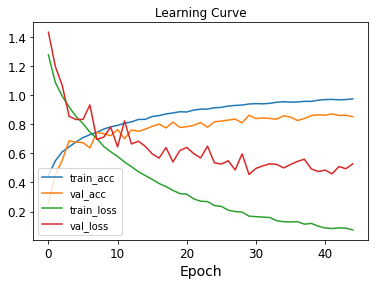

(3120, 27, 19, 1)


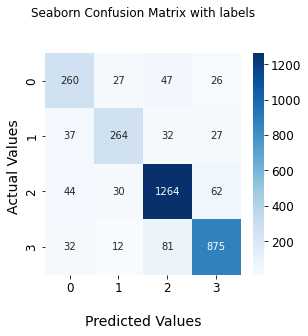

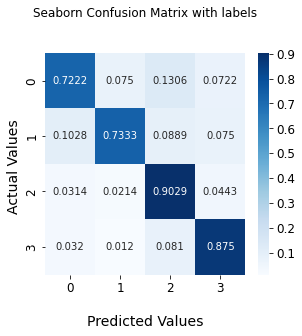

In [127]:
##################log 씌움
batch_size= 64
X_train
model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd',reshape=True, class_weight=True)



Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_64 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_65 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_66 (Batc (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 6, 4, 64)        

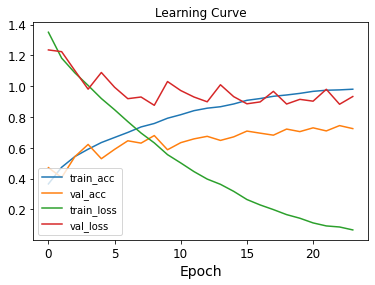

X_test_4 .shape :  (2496, 27, 19, 1)
y_test_4 .shape :  (2496,)


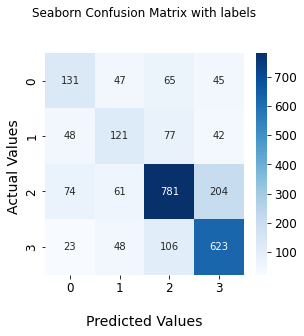

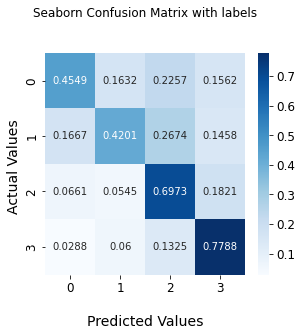

In [53]:
##################log 씌움 2
batch_size= 64

X_train_4 = np.log1p(X_train_4.reshape(-1,27,19,1))
X_test_4 = np.log1p(X_test_4.reshape(-1,27,19,1))

model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model = model,X_train = X_train_4, X_test = X_test_4,
            batch_size = batch_size, patience = 15,
            optimizer = 'sgd',reshape=False, class_weight=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 64)          0

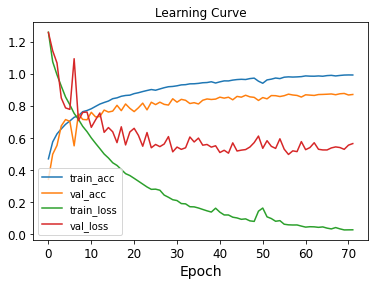

(3120, 27, 19, 1)


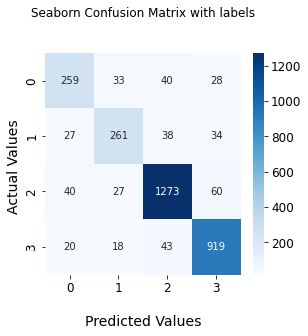

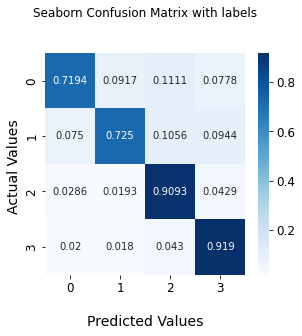

In [7]:
################## time domain
batch_size= 64
X_train
model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd',reshape=True, class_weight=True)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_5 (Batch (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 4, 64)         

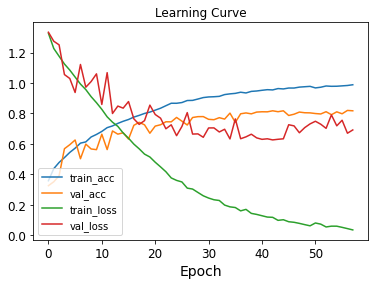

(3120, 27, 19, 1)


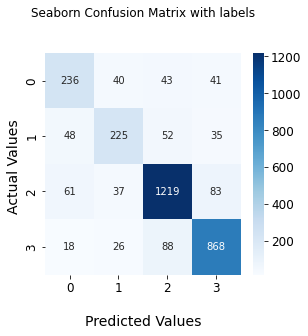

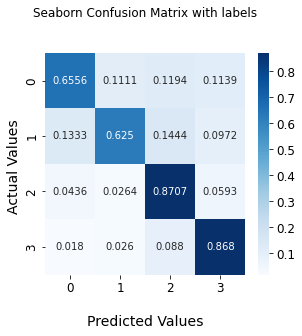

In [13]:
################## time domain +abs
batch_size= 64
model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd',reshape=True, class_weight=True)



In [21]:
# X_train.shape[1:]

(129, 6)

In [ ]:
input_shape = X_train

In [26]:
X_train.reshape((X_train.shape[1:],1))

TypeError: 'tuple' object cannot be interpreted as an integer

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_36 (Batc (None, 129, 6, 1)         4         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 129, 6, 16)        160       
_________________________________________________________________
batch_normalization_37 (Batc (None, 129, 6, 16)        64        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 3, 16)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 3, 64)         25664     
_________________________________________________________________
batch_normalization_38 (Batc (None, 64, 3, 64)         256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 1, 64)        

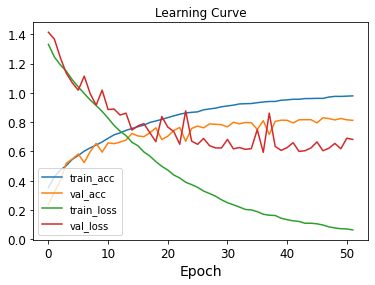

ValueError: cannot reshape array of size 2414880 into shape (27,19,1)

In [31]:
################## ifft -> stft  *1000
batch_size= 64
input_shape = ((129,6,1))

model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=3, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd',reshape=True, class_weight=True)



Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_48 (Batc (None, 43, 18, 1)         4         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 43, 18, 16)        416       
_________________________________________________________________
batch_normalization_49 (Batc (None, 43, 18, 16)        64        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 21, 9, 16)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 21, 9, 64)         25664     
_________________________________________________________________
batch_normalization_50 (Batc (None, 21, 9, 64)         256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 10, 4, 64)       

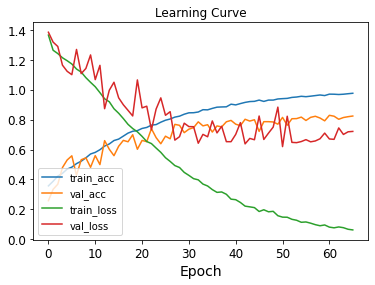

(3120, 43, 18, 1)


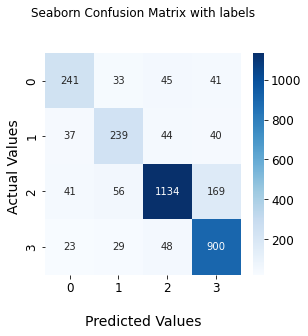

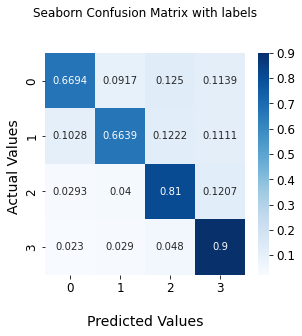

In [44]:
################## ifft -> stft  shape = (none,43,19,1)
batch_size= 64
input_shape = (43,18,1)

model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd',reshape=True, class_weight=True)



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_52 (Batc (None, 26, 22, 1)         4         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 26, 22, 16)        416       
_________________________________________________________________
batch_normalization_53 (Batc (None, 26, 22, 16)        64        
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 11, 16)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 13, 11, 64)        25664     
_________________________________________________________________
batch_normalization_54 (Batc (None, 13, 11, 64)        256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 5, 64)        

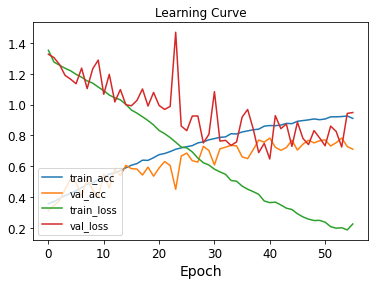

(3120, 26, 22, 1)


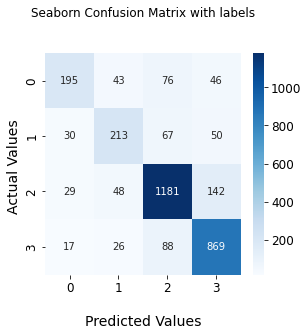

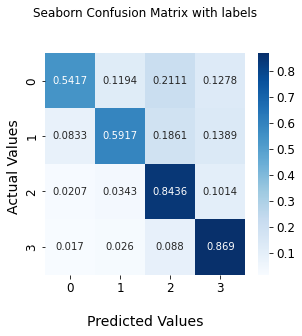

In [51]:
################## ifft -> stft  shape = (none,43,19,1)
batch_size= 64
input_shape = (X_train.shape[1],X_train.shape[2],1)

model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd',reshape=True, class_weight=True)



Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_56 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_57 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_58 (Batc (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 6, 4, 64)        

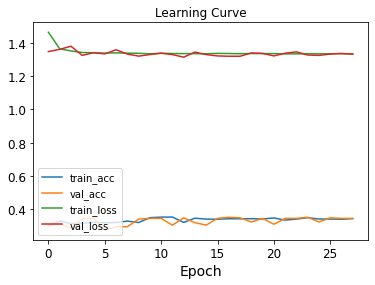

(3120, 27, 19, 1)


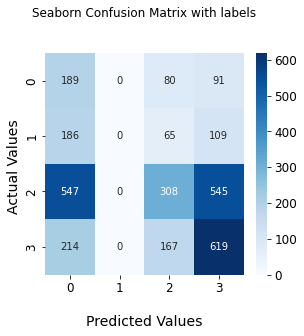

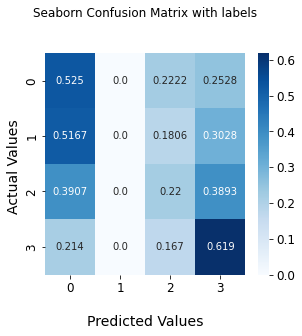

In [64]:
################## 첨도 shape = (none,27,19,1)
batch_size= 64
input_shape = (X_train.shape[1],X_train.shape[2],1)

model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd',reshape=True, class_weight=True)



In [76]:
#LeNet-5 구조
batch_size = 64

#LeNet-5 구조 -> maxpool 추가
batch_size = 64

input_layer = keras.Input(shape = (513,1))
x=keras.layers.Conv1D(16, kernel_size=5,strides=1,  activation='relu', padding='same')(input_layer) #C11
x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(64, kernel_size=5, strides=4, activation='relu', padding='valid')(x)
x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(128, kernel_size=5, strides=1, activation='tanh', padding='valid')(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(84, activation='tanh')(x)
out = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(input_layer,out)
model.summary()


train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd', class_weight=True)


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 513, 1)]          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 513, 16)           96        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 256, 16)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 63, 64)            5184      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 31, 64)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 27, 128)           41088     
_________________________________________________________________
flatten_18 (Flatten)         (None, 3456)              0   

KeyboardInterrupt: 

## googlenet

In [154]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import concatenate

# create an Inception block 
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 
  #   convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5 
  #   convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', 
                 activation = 'relu')(input_layer)

  # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', 
                 activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', 
                 activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', 
                 activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', 
                 activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', 
                 activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

def GoogLeNet_L(x,out_num = 1):
  # input layer 
#     input_layer = Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 1, padding = 'same', 
             activation = 'relu')(x)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 1)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', 
             activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', 
             activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 32, f2_conv3 = 128, f3_conv1 = 16, 
                      f3_conv5 = 32, f4 = 32)

#     # 2nd Inception block
#     X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, 
#                       f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, 
                      f3_conv5 = 48, f4 = 64)

    # Extra network 1:
#     X1 = AveragePooling2D(pool_size = (2,2), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', 
              activation = 'relu')(X)
    X1 = Flatten()(X1)
    X1 = Dense(512, activation = 'relu')(X1)
    X1 = Dropout(0.5)(X1)
    X1 = Dense(4, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, 
                      f3_conv5 = 64, f4 = 64)

#     # 5th Inception block
#     X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, 
#                       f3_conv5 = 64, f4 = 64)

#     # 6th Inception block
#     X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, 
#                       f3_conv5 = 64, f4 = 64)

    # Extra network 2:
#     X2 = AveragePooling2D(pool_size = (2,2), strides = 2)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', 
              activation = 'relu')(X)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(4, activation = 'softmax')(X2)


#     # 7th Inception block
#     X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
#                       f3_conv5 = 128, f4 = 128)

#     # max-pooling layer: pool_size = (3,3), strides = 2
#     X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

#     # 8th Inception block
#     X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
#                       f3_conv5 = 128, f4 = 128)

#     # 9th Inception block
#     X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, 
#                       f3_conv5 = 128, f4 = 128)

#     # Global Average pooling layer 
#     X = GlobalAveragePooling2D(name = 'GAPL')(X)

#     # Dropoutlayer 
#     X = Dropout(0.4)(X)

#     # output layer 
#     X = Dense(62, activation = 'softmax')(X)

    # model
    if out_num==1:
        model = Model(input_layer, X1, name = 'GoogLeNet')
    elif out_num==2:
        model = Model(input_layer, X2, name = 'GoogLeNet')
    else:
        model = Model(input_layer, X, name = 'GoogLeNet')

    return model


Model: "GoogLeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 27, 19, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_238 (Conv2D)             (None, 27, 19, 64)   3200        input_40[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_71 (MaxPooling2D) (None, 25, 17, 64)   0           conv2d_238[0][0]                 
__________________________________________________________________________________________________
conv2d_239 (Conv2D)             (None, 25, 17, 64)   4160        max_pooling2d_71[0][0]           
__________________________________________________________________________________________

156/156 [==============================] - 8s 45ms/step - loss: 1.6963 - accuracy: 0.3114 - val_loss: 1.3142 - val_accuracy: 0.3269
Epoch 2/100
156/156 [==============================] - 7s 42ms/step - loss: 1.3226 - accuracy: 0.3393 - val_loss: 1.3186 - val_accuracy: 0.3137
Epoch 3/100
156/156 [==============================] - 7s 44ms/step - loss: 1.2544 - accuracy: 0.3666 - val_loss: 1.4049 - val_accuracy: 0.2348
Epoch 4/100
156/156 [==============================] - 7s 43ms/step - loss: 1.2693 - accuracy: 0.3590 - val_loss: 1.1937 - val_accuracy: 0.4928
Epoch 5/100
156/156 [==============================] - 7s 44ms/step - loss: 1.1975 - accuracy: 0.4429 - val_loss: 1.1446 - val_accuracy: 0.5000
Epoch 6/100
156/156 [==============================] - 7s 45ms/step - loss: 1.1952 - accuracy: 0.4591 - val_loss: 1.0861 - val_accuracy: 0.5429
Epoch 7/100
156/156 [==============================] - 7s 45ms/step - loss: 1.1185 - accuracy: 0.5200 - val_loss: 1.1634 - val_accuracy: 0.4824
Epoc

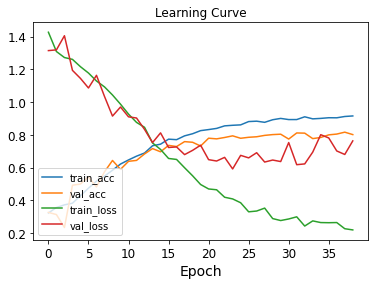

(3120, 27, 19, 1)


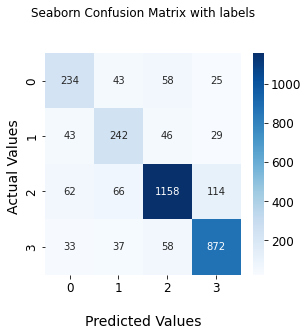

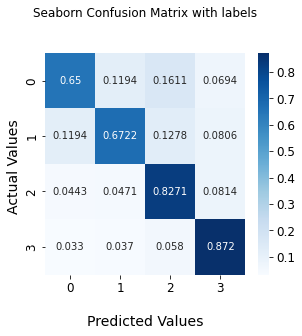

In [163]:
# google net 112,112
data_shape([X_train,X_test])
print(np.unique(y_train))

input_layer = Input(shape=(27,19,1))
# x = keras.layers.Conv2D(1, kernel_size=9, strides=1,  activation='relu', padding='same')(input_layer),

# x = keras.layers.Conv2D(3, kernel_size=5, strides=1,  activation='relu', padding='same')(input_layer),
model = GoogLeNet_L(input_layer,2)
# model = Model(input_layer,X)
model.summary()

batch_size= 64



train_model(model,X_train,X_test,batch_size=batch_size,patience = 15,optimizer = 'adam',reshape=True, class_weight=True)



## resnet

In [164]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

def build_resnet(input_shape=(27,19,1),
              num_cnn_list=[3,4,6],
              channel_list=[64,128,256],
              num_classes=62,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6]
        channel_list = [64,128,256]
        num_classes = 62
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

# resnet_50 = build_resnet(is_50 = True)
# plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
# plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

X_train .shape :  (12480, 513)
X_test .shape :  (3120, 513)
[0 1 2 3]
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 27, 19, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_264 (Conv2D)             (None, 13, 9, 64)    320         input_42[0][0]                   
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 13, 9, 64)    256         conv2d_264[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_78 (MaxPooling2D) (None, 6, 4, 64)     0           batch_normalization_84[0][0]     
______________________

156/156 [==============================] - 30s 170ms/step - loss: 2.3435 - accuracy: 0.3352 - val_loss: 1.4923 - val_accuracy: 0.3746
Epoch 2/100
156/156 [==============================] - 26s 166ms/step - loss: 1.2975 - accuracy: 0.4440 - val_loss: 1.2713 - val_accuracy: 0.4647
Epoch 3/100
156/156 [==============================] - 26s 168ms/step - loss: 1.1826 - accuracy: 0.5053 - val_loss: 1.1119 - val_accuracy: 0.5276
Epoch 4/100
156/156 [==============================] - 27s 175ms/step - loss: 1.1491 - accuracy: 0.5290 - val_loss: 1.4368 - val_accuracy: 0.3874
Epoch 5/100
156/156 [==============================] - 28s 182ms/step - loss: 1.0465 - accuracy: 0.5892 - val_loss: 0.9411 - val_accuracy: 0.6270
Epoch 6/100
156/156 [==============================] - 26s 164ms/step - loss: 0.9857 - accuracy: 0.6286 - val_loss: 1.0539 - val_accuracy: 0.5921
Epoch 7/100
156/156 [==============================] - 28s 180ms/step - loss: 0.9058 - accuracy: 0.6641 - val_loss: 1.0169 - val_accurac

Epoch 57/100
156/156 [==============================] - 81s 518ms/step - loss: 0.1175 - accuracy: 0.9513 - val_loss: 0.7276 - val_accuracy: 0.8381
Epoch 58/100
156/156 [==============================] - 88s 565ms/step - loss: 0.1082 - accuracy: 0.9590 - val_loss: 0.6747 - val_accuracy: 0.8482
Epoch 59/100
156/156 [==============================] - 85s 541ms/step - loss: 0.1346 - accuracy: 0.9467 - val_loss: 0.7405 - val_accuracy: 0.8201
Epoch 60/100
156/156 [==============================] - 88s 565ms/step - loss: 0.1357 - accuracy: 0.9430 - val_loss: 3.9360 - val_accuracy: 0.8249
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
training time:  0.0 h 52.0 m 2.1006431579589844 s
98/98 [==============================] - 25s 240ms/step - loss: 0.5852 - accuracy: 0.8279

-----test score :  [0.5851626396179199, 0.8278846144676208]


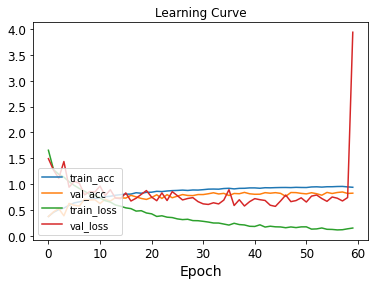

(3120, 27, 19, 1)


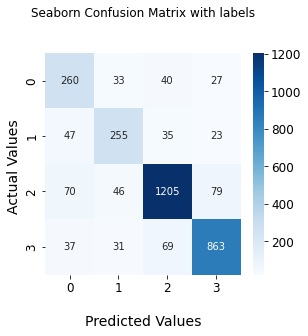

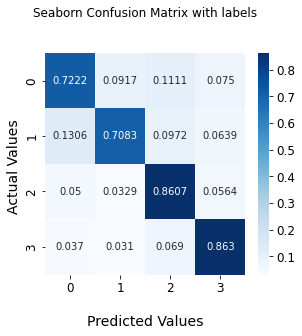

In [166]:
data_shape([X_train,X_test])
print(np.unique(y_train))

model = build_resnet(is_50 = False)
model.summary()
batch_size= 64

train_model(model,X_train,X_test,batch_size=batch_size,patience = 15,optimizer = 'adam',reshape=True, class_weight=True)

In [49]:
load_model_list('./model')
load_model_list('./model_4')


['2022-06-09_14_29.hdf5', '2022-06-14_11_20.hdf5', '2022-06-14_16_24.hdf5', '2022-06-14_16_30.hdf5', '2022-06-14_16_36.hdf5', '2022-06-14_17_07.hdf5', '2022-06-14_17_08.hdf5', '2022-06-14_17_10.hdf5', '2022-06-14_17_23.hdf5', '2022-06-14_17_24.hdf5', '2022-06-14_17_27.hdf5', '2022-06-14_17_47.hdf5', '2022-06-14_17_59.hdf5', '2022-06-14_18_03.hdf5', '2022-06-14_18_10.hdf5', '2022-06-14_18_14.hdf5', '2022-06-14_18_21.hdf5', '2022-06-14_18_33.hdf5', '2022-06-16_11_57.hdf5']
['2022-06-09_14_29.hdf5.csv']


[0 1 2 3 4]
Counter({2: 2563, 0: 1753, 1: 1367, 3: 1242, 4: 895})


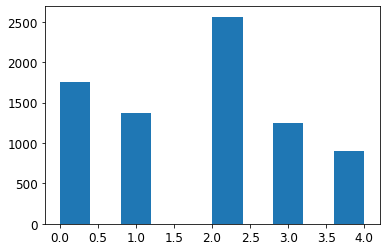

(7820,)
[0 1 2 3]
(5257,)
[0 1 3 4]
(7820,)
Counter({2: 2563, 0: 1870, 1: 1434, 3: 1114, 4: 839})


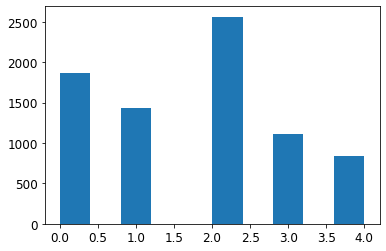

제출 할 csv 클래스 별 분포 :  leaktype
normal      2563
out         1870
in          1434
other       1114
noise        839
dtype: int64


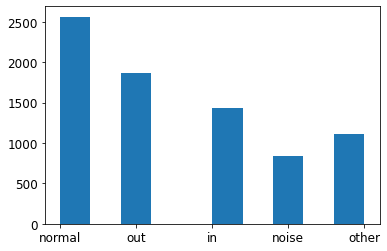

저장 파일 이름 06-14_18_33--4.csv


In [99]:
import collections

def make_test_csv_4(model,model_name,reshape=False, submit_test = submit_test):
    sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
    sample_pd.set_index('id',inplace=True)
    
    if reshape == True:
        submit_te = submit_test.reshape((-1,27,19,1))
    else:
        submit_te=submit_test
    
    
    model_1 = tf.keras.models.load_model('./model/'+model_name[0])
    model_2 = tf.keras.models.load_model('./model/'+model_name[1])
    
    pred_1 = np.argmax(model_1.predict(submit_te),axis = 1) #step1
    print(np.unique(pred_1))
    print(collections.Counter(pred_1)) #step 2하기 전 라벨
    plt.hist(pred_1)
    plt.show()
    
    submit_te_4_ind = np.where(pred_1!=2)[0]# step 2에 들어갈 X_test index
    submit_te_4 = submit_te[submit_te_4_ind] #step 2에 들어갈 X_test
    
    print(pred_1.shape)
    pred_2 = np.argmax(model_2.predict(submit_te_4),axis = 1)# step 2
    print(np.unique(pred_2))
    
    pred_2[pred_2 == 3]= 4
    pred_2[pred_2 == 2]= 3
    
    
    print(pred_2.shape)
    print(np.unique(pred_2))
    pred_1[submit_te_4_ind]= pred_2
    print(pred_1.shape)
    print(collections.Counter(pred_1)) #step 2한 후 라벨
    
    plt.hist(pred_1)
    plt.show()
    
    
    sub = pd.concat([test_pd.iloc[:,0],
                           pd.DataFrame(pred_1,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
    sub.set_index('id',inplace=True)
    submit_pd = sub.reindex(sample_pd.index)
    print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
    plt.hist(np.array(submit_pd))
    plt.show()
    
    MODEL_SAVE_FOLDER_PATH = './result_csv_4/' 
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name[0][5:-6]+'--4.csv')
    print('저장 파일 이름', model_name[0][5:-6]+'--4'+'.csv')
    
    return submit_pd


submit_pd = make_test_csv_4(model,model_name = ['2022-06-14_18_33.hdf5.','2022-06-16_11_57.hdf5'], reshape=True)


[0 1 2 3 4]
(33600,)


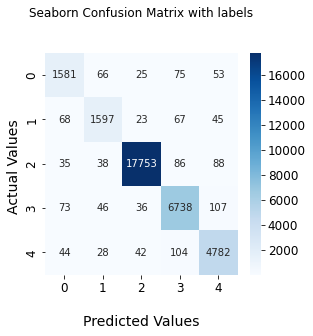

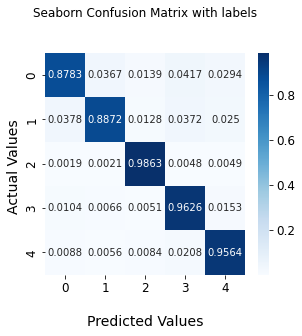

[0 1 2 3]
(15721,)
[0 1 3 4]
(33600,)


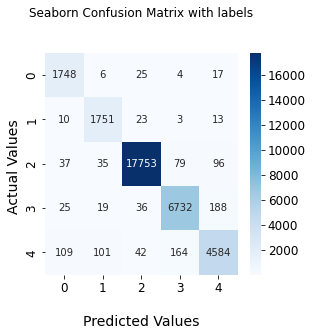

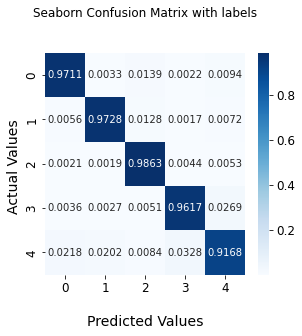

train_acc :  0.9692857142857143


In [102]:
def make_test_csv_val4(submit_test = X_train, label = y_train ,model_name=[], reshape=False, matrix = True):
    sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
    sample_pd.set_index('id',inplace=True)
    
    if reshape == True:
        submit_te = submit_test.reshape((-1,27,19,1))
    else:
        submit_te=submit_test
    
    
    model_1 = tf.keras.models.load_model('./model/'+model_name[0])
    model_2 = tf.keras.models.load_model('./model/'+model_name[1])
    pred_1 = np.argmax(model_1.predict(submit_te),axis = 1)
    print(np.unique(pred_1))
    
    submit_te_4_ind = np.where(pred_1!=2)[0]# step 2에 들어갈 X_test index
    submit_te_4 = submit_te[submit_te_4_ind] #step 2에 들어갈 X_test
    
    print(pred_1.shape)
    show_matrix(label,pred_1)
    
    
    ##여기부터 step 2
    pred_2 = np.argmax(model_2.predict(submit_te_4),axis = 1)
    print(np.unique(pred_2))
    
    pred_2[pred_2 == 3]= 4
    pred_2[pred_2 == 2]= 3
    
    
    print(pred_2.shape)
    print(np.unique(pred_2))
    pred_1[submit_te_4_ind]= pred_2
    print(pred_1.shape)
    
    show_matrix(label,pred_1)
    print('train_acc : ', pred_1[pred_1==label].shape[0]/pred_1.shape[0])
    
#     sub = pd.concat([test_pd.iloc[:,0],
#                            pd.DataFrame(pred_1,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
#     sub.set_index('id',inplace=True)
#     submit_pd = sub.reindex(sample_pd.index)
#     print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
#     plt.hist(np.array(submit_pd))
#     plt.show()
    
#     MODEL_SAVE_FOLDER_PATH = './result_csv_4/' 
#     if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
#         os.mkdir(MODEL_SAVE_FOLDER_PATH) 
#     submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name[0][:-5]+'--4.csv')
#     print('저장 파일 이름', model_name[0][:-6]+'--4'+'.csv')
    
#     return submit_pd


make_test_csv_val4(X_train,y_train,model_name = ['2022-06-14_18_33.hdf5.','2022-06-16_11_57.hdf5'], reshape=True)


[0 1 2 3 4]
(6720,)


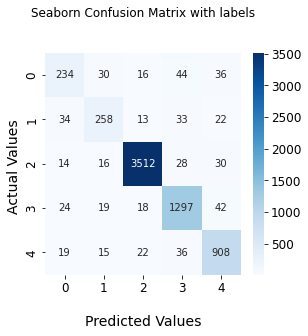

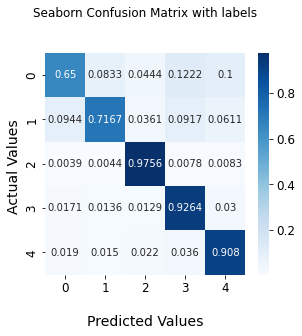

[0 1 2 3]
(3139,)
[0 1 3 4]
(6720,)


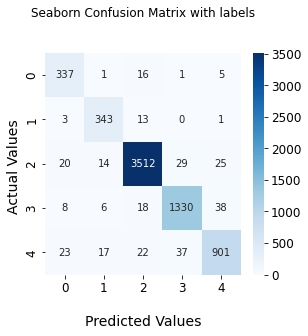

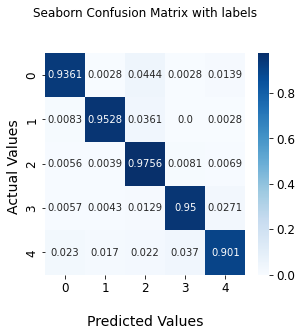

train_acc :  0.9558035714285714


In [10]:
def make_test_csv_val4(submit_test = X_test, label = y_test ,model_name=[], reshape=False, matrix = True):
    sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
    sample_pd.set_index('id',inplace=True)
    
    if reshape == True:
        submit_te = submit_test.reshape((-1,27,19,1))
    else:
        submit_te=submit_test
    
    
    model_1 = tf.keras.models.load_model('./model/'+model_name[0])
    model_2 = tf.keras.models.load_model('./model/'+model_name[1])
    pred_1 = np.argmax(model_1.predict(submit_te),axis = 1)
    print(np.unique(pred_1))
    
    submit_te_4_ind = np.where(pred_1!=2)[0]# step 2에 들어갈 X_test index
    submit_te_4 = submit_te[submit_te_4_ind] #step 2에 들어갈 X_test
    
    print(pred_1.shape)
    show_matrix(label,pred_1)
    
    
    ##여기부터 step 2
    pred_2 = np.argmax(model_2.predict(submit_te_4),axis = 1)
    print(np.unique(pred_2))
    
    pred_2[pred_2 == 3]= 4
    pred_2[pred_2 == 2]= 3
    
    
    print(pred_2.shape)
    print(np.unique(pred_2))
    pred_1[submit_te_4_ind]= pred_2
    print(pred_1.shape)
    
    show_matrix(label,pred_1)
    print('train_acc : ', pred_1[pred_1==label].shape[0]/pred_1.shape[0])
    
    sub = pd.concat([test_pd.iloc[:,0],
                           pd.DataFrame(pred_1,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
    sub.set_index('id',inplace=True)
    submit_pd = sub.reindex(sample_pd.index)
    print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
    plt.hist(np.array(submit_pd))
    plt.show()
    
    MODEL_SAVE_FOLDER_PATH = './result_csv_4/' 
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name[0][:-5]+'--4.csv')
    print('저장 파일 이름', model_name[0][:-6]+'--4'+'.csv')
    
    return submit_pd


make_test_csv_val4(X_test,y_test,model_name = ['2022-06-14_18_33.hdf5.','2022-06-16_11_57.hdf5'], reshape=True)
